## RNN model to predict Apple Stock price



In [1]:
# Part 1 - Data Preprocessing

# Importing the libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


Bad key "text.kerning_factor" on line 4 in
/Users/imanjani/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
dataset=pd.read_csv('data/AAPL.csv',parse_dates=['Date'])

print (dataset.shape)
dataset.tail()

(2026, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
2021,2019-01-15,150.270004,153.389999,150.050003,153.070007,153.070007,28710900
2022,2019-01-16,153.080002,155.880005,153.000000,154.940002,154.940002,30569700
2023,2019-01-17,154.199997,157.660004,153.259995,155.860001,155.860001,29821200
2024,2019-01-18,157.500000,157.880005,155.979996,156.820007,156.820007,33751000
2025,2019-01-22,156.410004,156.729996,152.619995,153.300003,153.300003,30278100




#### I want to train my model with openning price from 2011 to 12/2018 and then predict stock price for 2019

In [3]:
start=time.time()

test=dataset[dataset.Date >'2019-01-01'].iloc[:,1:2].values # price after 2019
train=dataset[dataset.Date <'2019-01-01'].iloc[:,1:2].values # price before 1/2019

test.shape , train.shape

((14, 1), (2012, 1))

In [4]:
# scaling

# we need to normalize train and test

from sklearn.preprocessing import MinMaxScaler

SC=MinMaxScaler()

train=SC.fit_transform(train)
test=SC.transform(test)



In [5]:

X_train=[]
y_train=[]

for i in range(80, 2012):   
    
    X_train.append(train[i-80:i,0])
    y_train.append(train[i,0])
    


# conver x and y toarray 

X_train , y_train = np.array(X_train) , np.array(y_train)

print (X_train.shape, y_train.shape)

(1932, 80) (1932,)


- for RNN model in keras we need a 3D input 
    * (batch_size, timesteps , input_dim)

In [6]:
X_train=np.reshape(X_train, (1932,80,1))  # 1932,80 is the shape of x_train adding another dimension
X_train.shape

(1932, 80, 1)

# RNN Model with 4 Layers

In [7]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import LSTM

# initialize the model
predictor=Sequential()

predictor.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))  
predictor.add(Dropout(rate=0.2)) 


predictor.add(LSTM(units=200, return_sequences=True))  
predictor.add(Dropout(rate=0.2))

predictor.add(LSTM(units=200, return_sequences=True))  
predictor.add(Dropout(rate=0.2))

predictor.add(LSTM(units=200))  
predictor.add(Dropout(rate=0.2))



predictor.add(Dense(units=1))
predictor.compile(optimizer='sgd', loss='mse')


predictor.summary()




Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 80, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 80, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 80, 200)           320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 80, 200)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)              

In [8]:
# fit the model 

%time predictor.fit(X_train,y_train , epochs=50 , batch_size=30, validation_split=0.05)

Train on 1835 samples, validate on 97 samples
Epoch 1/50
1835/1835 [==============================] - 19s 10ms/step - loss: 0.0473 - val_loss: 0.2439
Epoch 2/50
1835/1835 [==============================] - 17s 9ms/step - loss: 0.0322 - val_loss: 0.2067
Epoch 3/50
1835/1835 [==============================] - 18s 10ms/step - loss: 0.0267 - val_loss: 0.1601
Epoch 4/50
1835/1835 [==============================] - 17s 9ms/step - loss: 0.0192 - val_loss: 0.0851
Epoch 5/50
1835/1835 [==============================] - 18s 10ms/step - loss: 0.0108 - val_loss: 0.0414
Epoch 6/50
1835/1835 [==============================] - 17s 9ms/step - loss: 0.0046 - val_loss: 0.0177
Epoch 7/50
1835/1835 [==============================] - 16s 9ms/step - loss: 0.0021 - val_loss: 0.0126
Epoch 8/50
1835/1835 [==============================] - 16s 9ms/step - loss: 0.0016 - val_loss: 0.0122
Epoch 9/50
1835/1835 [==============================] - 16s 9ms/step - loss: 0.0016 - val_loss: 0.0123
Epoch 10/50
1835/1835 [=

In [9]:
# to save time save the model

predictor.save('apple_stock_predictor.h5')

In [10]:
inputs=dataset[len(train)-len(test)-80:]['Open'].values

print (inputs.shape)

(108,)


In [11]:
inputs=dataset['Open'].iloc[-120:,].values
print (inputs.shape)

inputs=inputs.reshape(-1,1)
inputs = SC.transform(inputs)

inputs.shape

(120,)


(120, 1)

In [12]:

X_test=[]

for i in range(80,120):
    X_test.append(inputs[i-80:i,0])
    
X_test= np.array(X_test)
X_test.shape

(40, 80)

In [13]:
# add one more dim

X_test=np.reshape(X_test,(40,80,1))
X_test.shape

(40, 80, 1)

In [14]:
predicted_price=predictor.predict(X_test)

predicted_price=SC.inverse_transform(predicted_price)

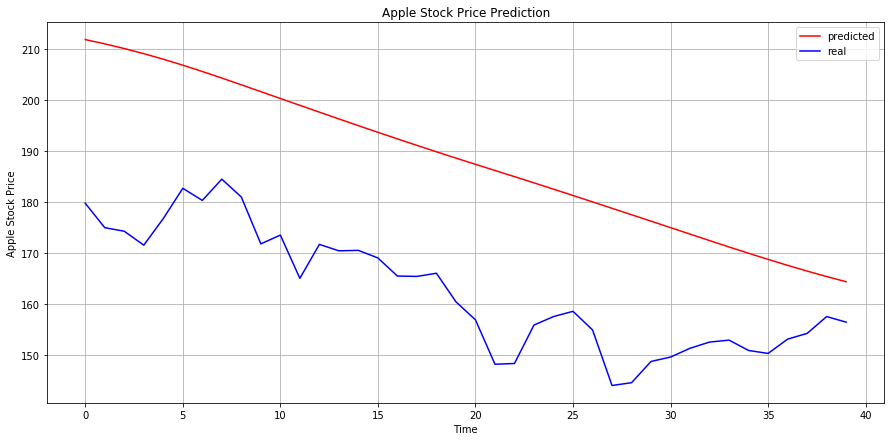

In [15]:

# we predict for the last 40 days and comapare it to real price now

real_price=dataset['Open'].iloc[-40:,].values


#Visualising the results
plt.figure(figsize=(15,7))
plt.plot(predicted_price, color='red', label='predicted')
plt.plot(real_price, color='blue', label='real')
plt.grid()
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()


In [16]:



# same model for the next 10 days 

train=dataset[dataset.Date <'2019-01-01'].iloc[:,1:2].values

from sklearn.preprocessing import MinMaxScaler

SC=MinMaxScaler()

train=SC.fit_transform(train)

X_train=[]
y_train=[]

for i in range(70, 2002):   
    X_train.append(train[i-70:i,0])
    y_train.append(train[i+10,0])
    


X_train , y_train = np.array(X_train) , np.array(y_train)

print (X_train.shape, y_train.shape)


(1932, 70) (1932,)


In [17]:
X_train=np.reshape(X_train, (1932,70,1))  # 1932,80 is the shape of x_train adding another dimension
X_train.shape

(1932, 70, 1)

In [18]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import LSTM

# initialize the model
predictor=Sequential()


predictor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))  
predictor.add(Dropout(rate=0.2)) 
predictor.add(LSTM(units=100, return_sequences=True))  
predictor.add(Dropout(rate=0.2))
predictor.add(LSTM(units=100, return_sequences=True))  
predictor.add(Dropout(rate=0.2))
predictor.add(LSTM(units=100))  
predictor.add(Dropout(rate=0.2))
predictor.add(Dense(units=1))


predictor.compile(optimizer='sgd', loss='mse')


# see the summary of model

predictor.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 70, 100)           40800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 70, 100)           80400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 70, 100)           80400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)              

In [19]:
# fit the model 

%time predictor.fit(X_train,y_train , epochs=15 , batch_size=30, validation_split=0.05)

Train on 1835 samples, validate on 97 samples
Epoch 1/15
1835/1835 [==============================] - 10s 5ms/step - loss: 0.0423 - val_loss: 0.2529
Epoch 2/15
1835/1835 [==============================] - 8s 5ms/step - loss: 0.0300 - val_loss: 0.1603
Epoch 3/15
1835/1835 [==============================] - 9s 5ms/step - loss: 0.0246 - val_loss: 0.1439
Epoch 4/15
1835/1835 [==============================] - 9s 5ms/step - loss: 0.0168 - val_loss: 0.0834
Epoch 5/15
1835/1835 [==============================] - 8s 5ms/step - loss: 0.0090 - val_loss: 0.0402
Epoch 6/15
1835/1835 [==============================] - 9s 5ms/step - loss: 0.0042 - val_loss: 0.0239
Epoch 7/15
1835/1835 [==============================] - 8s 5ms/step - loss: 0.0030 - val_loss: 0.0199
Epoch 8/15
1835/1835 [==============================] - 8s 5ms/step - loss: 0.0028 - val_loss: 0.0194
Epoch 9/15
1835/1835 [==============================] - 8s 5ms/step - loss: 0.0027 - val_loss: 0.0197
Epoch 10/15
1835/1835 [============

In [20]:
# to save time save the model

predictor.save('apple_stock_predictor2.h5')

In [21]:

inputs=dataset['Open'].iloc[-150:-20,].values

print (inputs.shape)

inputs=inputs.reshape(-1,1)

inputs = SC.transform(inputs)

inputs.shape

(130,)


(130, 1)

In [22]:
X_test=[]

for i in range(70,130):
    X_test.append(inputs[i-70:i,0])
    
X_test= np.array(X_test)
print (X_test.shape)





(60, 70)


In [23]:
X_test=np.reshape(X_test,(60,70,1))
X_test.shape


(60, 70, 1)

In [24]:
predicted_price=predictor.predict(X_test)

predicted_price=SC.inverse_transform(predicted_price)



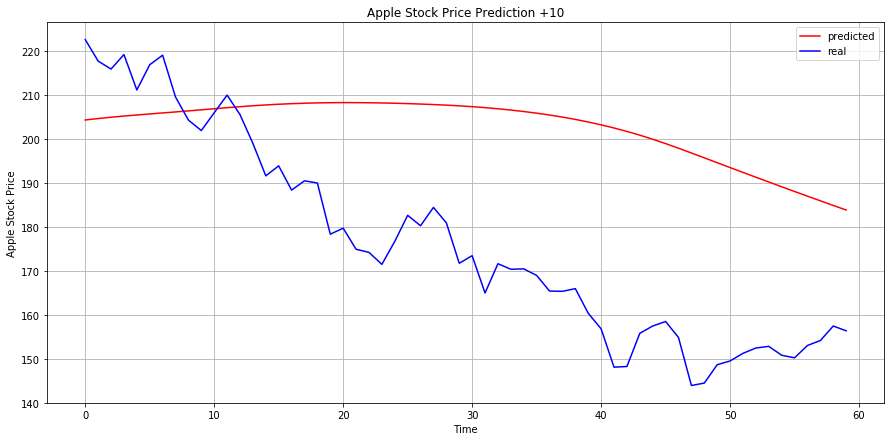

In [29]:
# we predict for the last 40 days and comapare it to real price now

real_price=dataset['Open'].iloc[-60:,].values


#Visualising the results
plt.figure(figsize=(15,7))
plt.plot(predicted_price, color='red', label='predicted')
plt.plot(real_price, color='blue', label='real')
plt.grid()
plt.title('Apple Stock Price Prediction +10')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()